### Imports and Configuration

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.quantization
from torch.ao.quantization import quantize_fx
import torch.nn.utils.prune as prune
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time
from tqdm import tqdm

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
NUM_WORKERS = 2
NUM_EPOCHS = 15
TEACHER_EPOCHS = 10

# Standard ImageNet normalization
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
device

device(type='cuda')

### Data Loading (CIFAR-10)

In [2]:
# Transforms
common_transform = transforms.Compose([
    transforms.Resize((32, 32)), # Ensure correct size for models
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 Dataset
train_cifar = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=common_transform)
test_cifar = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=common_transform)

cifar_train_loader = DataLoader(train_cifar, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
cifar_test_loader = DataLoader(test_cifar, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"CIFAR-10 Training Samples: {len(train_cifar)}")
print(f"CIFAR-10 Test Samples: {len(test_cifar)}")

100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]


CIFAR-10 Training Samples: 50000
CIFAR-10 Test Samples: 10000


### Helper Functions (Training & Evaluation)

In [3]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return 100.0 * correct / total

def train_standard(model, train_loader, val_loader, criterion, optimizer, epochs=5, device='cuda'):
    model.to(device)
    history = {'loss': [], 'val_acc': []} 
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        
        # Using tqdm for progress tracking
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
        epoch_loss = running_loss / len(train_loader)
        val_acc = evaluate(model, val_loader, device)
        
        history['loss'].append(epoch_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch [{epoch+1}/{epochs}] Summary - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {time.time()-start_time:.1f}s")
        
    return history

### Knowledge Distillation

In [4]:
class DistillationLoss(nn.Module):
    def __init__(self, T=4.0, alpha=0.5):
        super(DistillationLoss, self).__init__()
        self.T = T
        self.alpha = alpha

    def forward(self, student_logits, teacher_logits, labels):
        # Soft Targets
        soft_targets = F.softmax(teacher_logits / self.T, dim=1)
        student_log_softmax = F.log_softmax(student_logits / self.T, dim=1)
        
        # KL Divergence Loss
        distillation_loss = nn.KLDivLoss(reduction='batchmean')(student_log_softmax, soft_targets) * (self.T ** 2)
        
        # Student Loss (Standard CE)
        student_loss = F.cross_entropy(student_logits, labels)
        
        return self.alpha * distillation_loss + (1 - self.alpha) * student_loss

def train_distillation(student, teacher, train_loader, val_loader, criterion, optimizer, epochs=5, device='cuda'):
    student.to(device)
    teacher.to(device)
    teacher.eval() # Teacher is frozen
    
    history = {'loss': [], 'val_acc': []}

    print(f"Starting Distillation (T={criterion.T}, alpha={criterion.alpha})...")
    
    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Distill Epoch {epoch+1}/{epochs}")
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            with torch.no_grad():
                teacher_outputs = teacher(images)
            
            optimizer.zero_grad()
            student_outputs = student(images)
            
            loss = criterion(student_outputs, teacher_outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            
        epoch_loss = running_loss / len(train_loader)
        val_acc = evaluate(student, val_loader, device)
        
        history['loss'].append(epoch_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Distillation Epoch [{epoch+1}/{epochs}] Summary - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
    return history

### Grad-CAM Implementation

In [5]:
def denormalize(tensor, stats):
    """Reverts ImageNet normalization for visualization."""
    mean, std = stats
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        self.hooks = []
        
        self.hooks.append(target_layer.register_forward_hook(self.save_activation))
        self.hooks.append(target_layer.register_full_backward_hook(self.save_gradient))

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
            
        self.model.zero_grad()
        score = output[0, class_idx]
        score.backward()
        
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]
        
        weights = np.mean(gradients, axis=(1, 2))
        
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
            
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (x.shape[2], x.shape[3]))
        cam = cam - np.min(cam)
        cam = cam / (np.max(cam) + 1e-8)
        return cam

def visualize_gradcam(model, loader, device, stats):
    try:
        images, labels = next(iter(loader))
    except StopIteration:
        return
        
    images = images.to(device)
    target_layer = model.features[-1] 
    
    cam_extractor = GradCAM(model, target_layer)
    
    plt.figure(figsize=(15, 6))
    for i in range(min(5, len(images))):
        img_tensor = images[i:i+1]
        model.zero_grad()
        heatmap = cam_extractor(img_tensor)
        
        img_denorm = denormalize(images[i], stats).detach().cpu().permute(1, 2, 0).numpy()
        img_denorm = np.clip(img_denorm, 0, 1)
        
        heatmap = cv2.resize(heatmap, (img_denorm.shape[1], img_denorm.shape[0]))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255
        
        overlay = np.clip(heatmap * 0.4 + img_denorm * 0.6, 0, 1)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_denorm)
        plt.axis('off')
        plt.title(f"Label: {labels[i].item()}")
        
        plt.subplot(2, 5, i + 6)
        plt.imshow(overlay)
        plt.axis('off')
        plt.title("Grad-CAM")
    
    plt.tight_layout()
    plt.show()
    cam_extractor.remove_hooks()

### Pruning & SVD

In [6]:
def run_iterative_pruning(model, train_loader, criterion, optimizer, device, stages=3, amount=0.2):
    """Iterative Unstructured Pruning: Prune -> Retrain -> Repeat"""
    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            parameters_to_prune.append((module, 'weight'))
            
    for stage in range(stages):
        print(f"--- Pruning Stage {stage + 1}/{stages} ---")
        prune.global_unstructured(
            parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=amount,
        )
        
        # Fine-tune
        model.train()
        # Using a short loop for retraining to save time
        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Pruning Retrain")):
            if i >= 50: break # Limited batches for speed
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    for module, name in parameters_to_prune:
        prune.remove(module, name)
    print(f"Iterative pruning completed.")

def apply_svd_to_classifier(model, rank_fraction=0.5):
    classifier = model.classifier[1]
    weight = classifier.weight.data 
    
    U, S, Vh = torch.linalg.svd(weight, full_matrices=False)
    
    k = int(S.size(0) * rank_fraction)
    U_k = U[:, :k]
    S_k = torch.diag(S[:k])
    Vh_k = Vh[:k, :]
    
    layer1 = nn.Linear(Vh_k.shape[1], k, bias=False)
    layer2 = nn.Linear(k, U_k.shape[0], bias=True)
    
    layer1.weight.data = Vh_k
    layer2.weight.data = torch.mm(U_k, S_k)
    layer2.bias.data = classifier.bias.data
    
    model.classifier[1] = nn.Sequential(layer1, layer2)
    print(f"SVD applied. Classifier decomposed with rank {k}.")

### Robustness & Quantization

In [7]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return torch.clamp(perturbed_image, 0, 1)

def test_security_robustness(model, loader, epsilon=0.05, blur_sigma=0.0, device='cuda'):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    
    gaussian_blur = transforms.GaussianBlur(kernel_size=5, sigma=blur_sigma) if blur_sigma > 0 else None
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        if gaussian_blur:
            with torch.no_grad():
                images = gaussian_blur(images)
        
        if epsilon > 0:
            images.requires_grad = True
            output = model(images)
            loss = nn.CrossEntropyLoss()(output, labels)
            model.zero_grad()
            loss.backward()
            data_grad = images.grad.data
            perturbed_images = fgsm_attack(images, epsilon, data_grad)
            with torch.no_grad():
                output = model(perturbed_images)
        else:
            with torch.no_grad():
                output = model(images)

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    acc = 100.0 * correct / total
    return acc

def quantize_model_fx(model, data_loader, device='cpu'):
    quant_device = torch.device('cpu')
    model.eval()
    model.to(quant_device)
    qconfig_dict = {"": torch.quantization.get_default_qconfig('fbgemm')}

    try:
        example_batch = next(iter(data_loader))[0]
    except StopIteration:
        raise ValueError("Data loader is empty.")
    example_input = example_batch.to(quant_device)
    
    model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, (example_input,))
    
    print("Calibrating model (on CPU)...")
    with torch.inference_mode():
        for i, (images, _) in enumerate(data_loader):
            images = images.to(quant_device)
            model_prepared(images)
            if i >= 20: break 

    model_quantized = quantize_fx.convert_fx(model_prepared)
    print("Quantization (FX) complete.")
    return model_quantized

### Report Generation

In [8]:
def generate_report_table(model_partial, model_full, model_distilled, train_loader, test_loader, device):
    results = []
    models = {
        "Partial Tuning": model_partial,
        "Full Fine-Tuning": model_full,
        "Distillation": model_distilled
    }
    
    for name, model in models.items():
        if model is None: continue
        print(f"\nEvaluating metrics for {name}...")
        
        # 1. Base Accuracy
        base_acc = evaluate(model, test_loader, device)
        
        # 2. Structured Pruning
        print(f"  > Running Structured Pruning...")
        model_struc = copy.deepcopy(model)
        module = model_struc.classifier[1]
        prune.ln_structured(module, name="weight", amount=0.4, n=2, dim=0)
        
        # Quick retrain
        optimizer_struc = optim.Adam(model_struc.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()
        model_struc.train()
        for i, (images, labels) in enumerate(train_loader):
            if i > 20: break
            images, labels = images.to(device), labels.to(device)
            optimizer_struc.zero_grad()
            outputs = model_struc(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_struc.step()
            
        prune.remove(module, 'weight')
        struc_acc = evaluate(model_struc, test_loader, device)

        # 3. Unstructured Pruning
        print(f"  > Running Iterative Unstructured Pruning...")
        model_unstruc = copy.deepcopy(model)
        optimizer_prune = optim.Adam(model_unstruc.parameters(), lr=1e-4)
        criterion_prune = nn.CrossEntropyLoss()
        run_iterative_pruning(model_unstruc, train_loader, criterion_prune, optimizer_prune, device, stages=3, amount=0.2)
        unstruc_acc = evaluate(model_unstruc, test_loader, device)
        
        # 4. Quantization
        model_to_quant = copy.deepcopy(model)
        model_int8 = quantize_model_fx(model_to_quant, train_loader, device) 
        quant_acc = evaluate(model_int8, test_loader, device='cpu') 
        
        # 5. Robustness
        blur_acc = test_security_robustness(model, test_loader, blur_sigma=1.0, epsilon=0.0, device=device)
        fgsm_acc = test_security_robustness(model, test_loader, blur_sigma=0.0, epsilon=0.05, device=device)
        
        results.append({
            "Method": name,
            "Base Acc": f"{base_acc:.2f}%",
            "Gaussian Blur": f"{blur_acc:.2f}%",      
            "FGSM Attack": f"{fgsm_acc:.2f}%",
            "Unstruct. Pruning": f"{unstruc_acc:.2f}%",
            "Struct. Pruning": f"{struc_acc:.2f}%",
            "Quantized": f"{quant_acc:.2f}%",
        })
    
    return pd.DataFrame(results)

### Main Execution Pipeline (CIFAR-10)


==================== Running Pipeline on CIFAR-10 ====================
--- Method A: Partial Tuning ---
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 180MB/s]
Epoch 1/15: 100%|██████████| 782/782 [00:10<00:00, 72.69it/s, loss=1.65]


Epoch [1/15] Summary - Loss: 1.7563, Val Acc: 45.46%, Time: 12.8s


Epoch 2/15: 100%|██████████| 782/782 [00:10<00:00, 76.61it/s, loss=1.27]


Epoch [2/15] Summary - Loss: 1.6845, Val Acc: 46.21%, Time: 12.2s


Epoch 3/15: 100%|██████████| 782/782 [00:10<00:00, 76.62it/s, loss=1.25]


Epoch [3/15] Summary - Loss: 1.6707, Val Acc: 46.43%, Time: 12.1s


Epoch 4/15: 100%|██████████| 782/782 [00:10<00:00, 74.66it/s, loss=1.25]


Epoch [4/15] Summary - Loss: 1.6756, Val Acc: 46.26%, Time: 12.4s


Epoch 5/15: 100%|██████████| 782/782 [00:10<00:00, 75.73it/s, loss=1.24]


Epoch [5/15] Summary - Loss: 1.6656, Val Acc: 46.28%, Time: 12.3s


Epoch 6/15: 100%|██████████| 782/782 [00:09<00:00, 80.07it/s, loss=1.52]


Epoch [6/15] Summary - Loss: 1.6677, Val Acc: 45.87%, Time: 11.8s


Epoch 7/15: 100%|██████████| 782/782 [00:09<00:00, 79.60it/s, loss=2.38]


Epoch [7/15] Summary - Loss: 1.6735, Val Acc: 45.56%, Time: 11.8s


Epoch 8/15: 100%|██████████| 782/782 [00:10<00:00, 75.59it/s, loss=2.12]


Epoch [8/15] Summary - Loss: 1.6674, Val Acc: 46.53%, Time: 12.3s


Epoch 9/15: 100%|██████████| 782/782 [00:10<00:00, 77.91it/s, loss=1.23]


Epoch [9/15] Summary - Loss: 1.6720, Val Acc: 46.13%, Time: 12.0s


Epoch 10/15: 100%|██████████| 782/782 [00:10<00:00, 75.09it/s, loss=1.81]


Epoch [10/15] Summary - Loss: 1.6763, Val Acc: 45.32%, Time: 12.3s


Epoch 11/15: 100%|██████████| 782/782 [00:09<00:00, 78.83it/s, loss=1.74]


Epoch [11/15] Summary - Loss: 1.6758, Val Acc: 46.93%, Time: 11.9s


Epoch 12/15: 100%|██████████| 782/782 [00:09<00:00, 79.40it/s, loss=1.63]


Epoch [12/15] Summary - Loss: 1.6708, Val Acc: 46.23%, Time: 11.7s


Epoch 13/15: 100%|██████████| 782/782 [00:09<00:00, 78.36it/s, loss=1.77]


Epoch [13/15] Summary - Loss: 1.6750, Val Acc: 46.80%, Time: 11.9s


Epoch 14/15: 100%|██████████| 782/782 [00:10<00:00, 73.63it/s, loss=2.35]


Epoch [14/15] Summary - Loss: 1.6652, Val Acc: 44.93%, Time: 12.6s


Epoch 15/15: 100%|██████████| 782/782 [00:10<00:00, 78.18it/s, loss=1.25]


Epoch [15/15] Summary - Loss: 1.6715, Val Acc: 46.98%, Time: 12.0s
--- Method B: Full Fine-Tuning ---


Epoch 1/15: 100%|██████████| 782/782 [00:20<00:00, 38.59it/s, loss=2.13]


Epoch [1/15] Summary - Loss: 1.4392, Val Acc: 55.83%, Time: 22.3s


Epoch 2/15: 100%|██████████| 782/782 [00:19<00:00, 39.52it/s, loss=1.75]


Epoch [2/15] Summary - Loss: 1.2269, Val Acc: 59.80%, Time: 21.7s


Epoch 3/15: 100%|██████████| 782/782 [00:20<00:00, 38.62it/s, loss=1.42]


Epoch [3/15] Summary - Loss: 1.1140, Val Acc: 62.90%, Time: 22.2s


Epoch 4/15: 100%|██████████| 782/782 [00:19<00:00, 39.57it/s, loss=1.7]


Epoch [4/15] Summary - Loss: 1.0212, Val Acc: 64.97%, Time: 21.7s


Epoch 5/15: 100%|██████████| 782/782 [00:20<00:00, 38.73it/s, loss=1.41]


Epoch [5/15] Summary - Loss: 0.9581, Val Acc: 66.10%, Time: 22.1s


Epoch 6/15: 100%|██████████| 782/782 [00:20<00:00, 38.50it/s, loss=0.951]


Epoch [6/15] Summary - Loss: 0.9024, Val Acc: 68.08%, Time: 22.3s


Epoch 7/15: 100%|██████████| 782/782 [00:20<00:00, 38.93it/s, loss=1.14]


Epoch [7/15] Summary - Loss: 0.8530, Val Acc: 68.78%, Time: 22.0s


Epoch 8/15: 100%|██████████| 782/782 [00:20<00:00, 38.68it/s, loss=0.667]


Epoch [8/15] Summary - Loss: 0.8076, Val Acc: 69.65%, Time: 22.2s


Epoch 9/15: 100%|██████████| 782/782 [00:19<00:00, 39.10it/s, loss=1.45]


Epoch [9/15] Summary - Loss: 0.7707, Val Acc: 70.33%, Time: 21.9s


Epoch 10/15: 100%|██████████| 782/782 [00:19<00:00, 39.74it/s, loss=1.7]


Epoch [10/15] Summary - Loss: 0.7351, Val Acc: 71.16%, Time: 21.7s


Epoch 11/15: 100%|██████████| 782/782 [00:20<00:00, 39.04it/s, loss=1.16]


Epoch [11/15] Summary - Loss: 0.7011, Val Acc: 71.89%, Time: 22.0s


Epoch 12/15: 100%|██████████| 782/782 [00:20<00:00, 38.89it/s, loss=1.41]


Epoch [12/15] Summary - Loss: 0.6724, Val Acc: 72.24%, Time: 22.0s


Epoch 13/15: 100%|██████████| 782/782 [00:20<00:00, 38.56it/s, loss=1.02]


Epoch [13/15] Summary - Loss: 0.6464, Val Acc: 72.49%, Time: 22.2s


Epoch 14/15: 100%|██████████| 782/782 [00:20<00:00, 38.93it/s, loss=1.43]


Epoch [14/15] Summary - Loss: 0.6203, Val Acc: 73.10%, Time: 22.0s


Epoch 15/15: 100%|██████████| 782/782 [00:20<00:00, 38.68it/s, loss=1.11]


Epoch [15/15] Summary - Loss: 0.5931, Val Acc: 73.87%, Time: 22.2s
--- Method C: Distillation (Teacher: ResNet50 -> Student: MobileNetV2) ---
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 209MB/s]


Training Teacher...


Epoch 1/10: 100%|██████████| 782/782 [00:12<00:00, 63.44it/s, loss=1.97]


Epoch [1/10] Summary - Loss: 1.6373, Val Acc: 48.62%, Time: 14.7s


Epoch 2/10: 100%|██████████| 782/782 [00:12<00:00, 63.56it/s, loss=1.41]


Epoch [2/10] Summary - Loss: 1.4853, Val Acc: 51.06%, Time: 14.6s


Epoch 3/10: 100%|██████████| 782/782 [00:12<00:00, 63.87it/s, loss=1.9]


Epoch [3/10] Summary - Loss: 1.4424, Val Acc: 51.72%, Time: 14.6s


Epoch 4/10: 100%|██████████| 782/782 [00:12<00:00, 63.67it/s, loss=1.37]


Epoch [4/10] Summary - Loss: 1.4189, Val Acc: 51.80%, Time: 14.6s


Epoch 5/10: 100%|██████████| 782/782 [00:12<00:00, 63.04it/s, loss=1.49]


Epoch [5/10] Summary - Loss: 1.3930, Val Acc: 51.61%, Time: 14.8s


Epoch 6/10: 100%|██████████| 782/782 [00:12<00:00, 62.68it/s, loss=1.61]


Epoch [6/10] Summary - Loss: 1.3917, Val Acc: 51.83%, Time: 14.7s


Epoch 7/10: 100%|██████████| 782/782 [00:12<00:00, 62.49it/s, loss=1]


Epoch [7/10] Summary - Loss: 1.3817, Val Acc: 53.16%, Time: 14.8s


Epoch 8/10: 100%|██████████| 782/782 [00:12<00:00, 62.98it/s, loss=1.68]


Epoch [8/10] Summary - Loss: 1.3807, Val Acc: 53.06%, Time: 14.7s


Epoch 9/10: 100%|██████████| 782/782 [00:12<00:00, 63.28it/s, loss=1.9]


Epoch [9/10] Summary - Loss: 1.3757, Val Acc: 51.83%, Time: 14.7s


Epoch 10/10: 100%|██████████| 782/782 [00:12<00:00, 63.07it/s, loss=1.39]


Epoch [10/10] Summary - Loss: 1.3723, Val Acc: 53.44%, Time: 14.7s
Starting Distillation (T=4.0, alpha=0.5)...


Distill Epoch 1/15: 100%|██████████| 782/782 [00:23<00:00, 32.76it/s, loss=1.88]


Distillation Epoch [1/15] Summary - Loss: 1.8591, Val Acc: 40.09%


Distill Epoch 2/15: 100%|██████████| 782/782 [00:24<00:00, 32.47it/s, loss=1.52]


Distillation Epoch [2/15] Summary - Loss: 1.5294, Val Acc: 49.69%


Distill Epoch 3/15: 100%|██████████| 782/782 [00:24<00:00, 32.25it/s, loss=1.31]


Distillation Epoch [3/15] Summary - Loss: 1.4066, Val Acc: 53.90%


Distill Epoch 4/15: 100%|██████████| 782/782 [00:23<00:00, 33.00it/s, loss=1.39]


Distillation Epoch [4/15] Summary - Loss: 1.3158, Val Acc: 58.36%


Distill Epoch 5/15: 100%|██████████| 782/782 [00:24<00:00, 32.24it/s, loss=1.39]


Distillation Epoch [5/15] Summary - Loss: 1.2476, Val Acc: 60.85%


Distill Epoch 6/15: 100%|██████████| 782/782 [00:24<00:00, 32.51it/s, loss=1.95]


Distillation Epoch [6/15] Summary - Loss: 1.1915, Val Acc: 63.86%


Distill Epoch 7/15: 100%|██████████| 782/782 [00:24<00:00, 32.44it/s, loss=1.42]


Distillation Epoch [7/15] Summary - Loss: 1.1392, Val Acc: 65.61%


Distill Epoch 8/15: 100%|██████████| 782/782 [00:24<00:00, 32.53it/s, loss=1.2]


Distillation Epoch [8/15] Summary - Loss: 1.0987, Val Acc: 67.22%


Distill Epoch 9/15: 100%|██████████| 782/782 [00:24<00:00, 32.05it/s, loss=1.13]


Distillation Epoch [9/15] Summary - Loss: 1.0632, Val Acc: 68.50%


Distill Epoch 10/15: 100%|██████████| 782/782 [00:24<00:00, 32.21it/s, loss=1.16]


Distillation Epoch [10/15] Summary - Loss: 1.0334, Val Acc: 69.35%


Distill Epoch 11/15: 100%|██████████| 782/782 [00:23<00:00, 33.04it/s, loss=1.04]


Distillation Epoch [11/15] Summary - Loss: 1.0053, Val Acc: 69.78%


Distill Epoch 12/15: 100%|██████████| 782/782 [00:24<00:00, 32.47it/s, loss=0.878]


Distillation Epoch [12/15] Summary - Loss: 0.9790, Val Acc: 70.81%


Distill Epoch 13/15: 100%|██████████| 782/782 [00:24<00:00, 32.44it/s, loss=1.26]


Distillation Epoch [13/15] Summary - Loss: 0.9630, Val Acc: 71.51%


Distill Epoch 14/15: 100%|██████████| 782/782 [00:24<00:00, 32.08it/s, loss=0.987]


Distillation Epoch [14/15] Summary - Loss: 0.9426, Val Acc: 72.26%


Distill Epoch 15/15: 100%|██████████| 782/782 [00:24<00:00, 31.81it/s, loss=1.57]


Distillation Epoch [15/15] Summary - Loss: 0.9265, Val Acc: 72.61%
--- Visualizing Grad-CAM (Full Model) ---


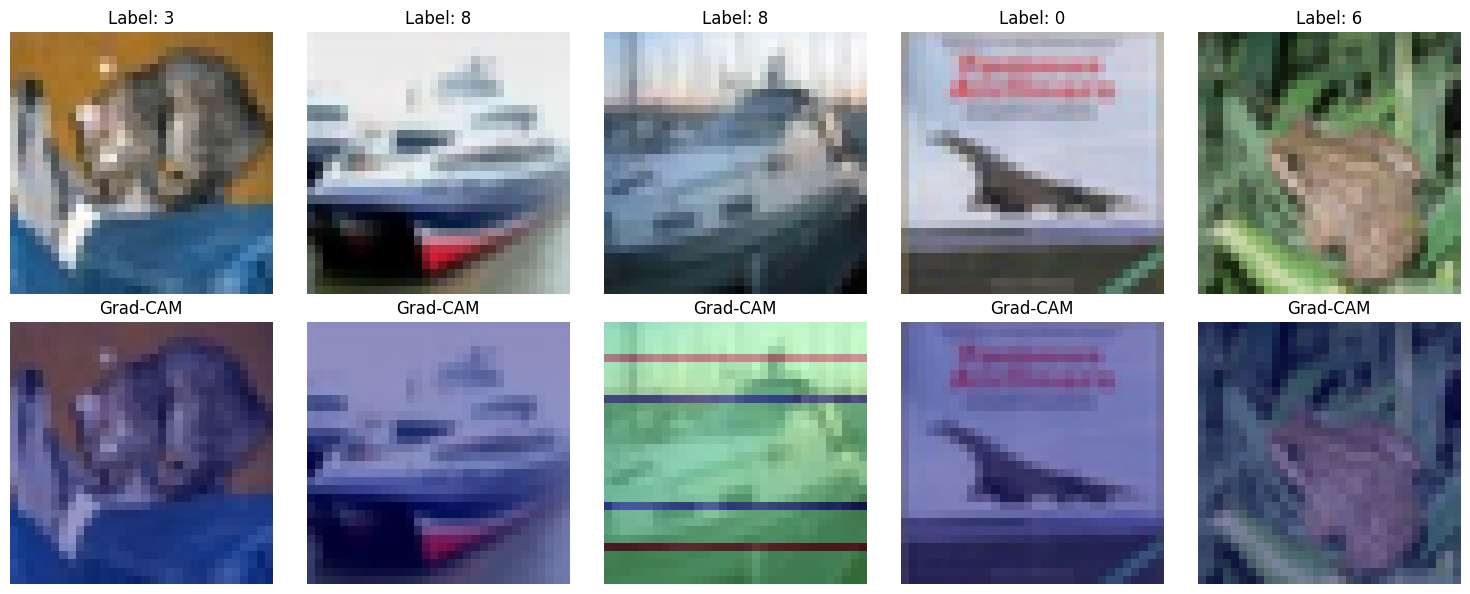

--- Generating Final Comparison Table ---

Evaluating metrics for Partial Tuning...
  > Running Structured Pruning...
  > Running Iterative Unstructured Pruning...
--- Pruning Stage 1/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:00<00:12, 59.87it/s]


--- Pruning Stage 2/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:00<00:13, 53.48it/s]


--- Pruning Stage 3/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:00<00:12, 56.96it/s]

Iterative pruning completed.



/tmp/ipykernel_24/2214206234.py:54: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, (example_input,))
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass i

Calibrating model (on CPU)...


/tmp/ipykernel_24/2214206234.py:63: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_fx.convert_fx(model_prepared)


Quantization (FX) complete.

Evaluating metrics for Full Fine-Tuning...
  > Running Structured Pruning...
  > Running Iterative Unstructured Pruning...
--- Pruning Stage 1/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:01<00:22, 32.57it/s]


--- Pruning Stage 2/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:01<00:23, 31.69it/s]


--- Pruning Stage 3/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:01<00:22, 32.22it/s]

Iterative pruning completed.



/tmp/ipykernel_24/2214206234.py:54: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, (example_input,))
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass i

Calibrating model (on CPU)...


/tmp/ipykernel_24/2214206234.py:63: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_fx.convert_fx(model_prepared)


Quantization (FX) complete.

Evaluating metrics for Distillation...
  > Running Structured Pruning...
  > Running Iterative Unstructured Pruning...
--- Pruning Stage 1/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:01<00:20, 35.39it/s]


--- Pruning Stage 2/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:01<00:24, 29.65it/s]


--- Pruning Stage 3/3 ---


Pruning Retrain:   6%|▋         | 50/782 [00:01<00:25, 28.42it/s]

Iterative pruning completed.



/tmp/ipykernel_24/2214206234.py:54: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_prepared = quantize_fx.prepare_fx(model, qconfig_dict, (example_input,))
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported in a future version. Please pass i

Calibrating model (on CPU)...


/tmp/ipykernel_24/2214206234.py:63: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_quantized = quantize_fx.convert_fx(model_prepared)


Quantization (FX) complete.


,Method,Base Acc,Gaussian Blur,FGSM Attack,Unstruct. Pruning,Struct. Pruning,Quantized
0,Partial Tuning,46.98%,27.22%,16.13%,19.12%,38.89%,34.40%
1,Full Fine-Tuning,73.87%,42.82%,25.77%,62.56%,56.82%,66.86%
2,Distillation,72.61%,47.56%,24.95%,70.10%,56.54%,72.16%


In [9]:
print(f"\n{'='*20} Running Pipeline on CIFAR-10 {'='*20}")

# --- A. Partial Fine-Tuning ---
print(f"--- Method A: Partial Tuning ---")
model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)

# Freeze features
for param in model.features.parameters():
    param.requires_grad = False
    
# Replace classifier (CIFAR-10 has 10 classes)
model.classifier[1] = nn.Linear(model.last_channel, 10)
model.to(device)

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_standard(model, cifar_train_loader, cifar_test_loader, criterion, optimizer, epochs=NUM_EPOCHS, device=device)
model_partial = copy.deepcopy(model)

# --- B. Full Fine-Tuning ---
print(f"--- Method B: Full Fine-Tuning ---")
# Unfreeze all
for param in model.parameters():
    param.requires_grad = True
    
optimizer_full = optim.Adam(model.parameters(), lr=1e-5)
train_standard(model, cifar_train_loader, cifar_test_loader, criterion, optimizer_full, epochs=NUM_EPOCHS, device=device)
model_full = model 

# --- C. Knowledge Distillation ---
print(f"--- Method C: Distillation (Teacher: ResNet50 -> Student: MobileNetV2) ---")

# Prepare Teacher
teacher = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
for param in teacher.parameters():
    param.requires_grad = False
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
for param in teacher.fc.parameters():
    param.requires_grad = True
teacher.to(device)

print("Training Teacher...")
optimizer_teacher = optim.Adam(teacher.fc.parameters(), lr=0.001)
train_standard(teacher, cifar_train_loader, cifar_test_loader, criterion, optimizer_teacher, epochs=TEACHER_EPOCHS, device=device)

# Train Student with Distillation
student = mobilenet_v2(weights=None)
student.classifier[1] = nn.Linear(student.last_channel, 10)
student.to(device)

optimizer_distill = optim.Adam(student.parameters(), lr=0.001)
kd_criterion = DistillationLoss(T=4.0, alpha=0.5)

train_distillation(student, teacher, cifar_train_loader, cifar_test_loader, kd_criterion, optimizer_distill, epochs=NUM_EPOCHS, device=device)
model_distilled = student

# --- Visualization & Report ---
print(f"--- Visualizing Grad-CAM (Full Model) ---")
visualize_gradcam(model_full, cifar_test_loader, device, stats)

print(f"--- Generating Final Comparison Table ---")
df_results = generate_report_table(
    model_partial=model_partial,
    model_full=model_full,
    model_distilled=model_distilled,
    train_loader=cifar_train_loader,       
    test_loader=cifar_test_loader,
    device=device
)

from IPython.display import display
display(df_results)